In [1]:
import os, sys, re
from time import time
import tqdm
import numpy, pandas
import sklearn.model_selection
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
def timed(f):
    """A decorator that prints out the execution time of a function"""
    def time_decorator(*args, **kwargs):
        t = time()
        res = f(*args, **kwargs)
        print('Execution of "{}()": {:.2f}s'.format(f.__name__, time()-t))
        return res
    return time_decorator

# CSE6240 Project 2:LSTMs for Language Detection
## Timothée Monceaux -  Robin Ricard - 04/24/2017

___

<span style="color:darkblue"><b><u>Note:</u></b> in this report, the instructions are in black while our notes/comments/answers are in darkblue. The code is also largely commented.</span><br><br>
<h3 style="color:darkblue">Important: This notebook is not exhaustive. Please read our [blog post](http://timothee.monceaux.me/blog/2017/04/24/lstm-for-language-detection.html) to consider our whole work for this project.</h3>
___

LSTMs are useful for building character-sequential prediction models. In this project you will use it to build string scoring models which you will then combine into a single language detector.

To begin, please refresh you background on LSTMs:

* [http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [http://karpathy.github.io/2015/05/21/rnn-effectiveness/](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Part 1 -- Building String Scoring Models [100 points]
* Download this dataset, [http://cloudmark.github.io/data/subset.zip](http://cloudmark.github.io/data/subset.zip) , which is used in this blog, [http://cloudmark.github.io/Language-Detection-Implemenation/](http://cloudmark.github.io/Language-Detection-Implemenation/) , for a language detection experiment. Note that the zip archive contains 23 files, each is the same text translated into a different language.


In [3]:
assert(os.path.isfile('data/frn.txt'))
assert(os.path.isfile('data/eng.txt'))

* Review the Keras documentation and example on LSTM for text generation at [https://keras.io/getting-started/sequential-model-guide/](https://keras.io/getting-started/sequential-model-guide/) and [https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py). The example, in particular shows how to train an LSTM model. Note that we will not be using the sample generation part of the code (feel free to look at it, though).

* For eng.txt and jap.txt, split each file into 80/20 learning/holdout subsets. Lowercase all of the letters for simplicity.

In [4]:
class Dataset:
    """Read, Preprocess, and Split the Data"""
    
    def __init__(self, text='data/eng.txt', substr_size=5, standard_charset=True):
        """Initialize the object and preprocess the data"""
        self.text = self.preprocess(open(text).read()) # the original text/corpus
        self.substr_size = substr_size # the n from our n-grams
        self.length = len(self.text)-self.substr_size-1 # the size of our complete dataset
        
        if standard_charset: # We use the default, hard-coded charset
            chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', \
                    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', \
                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
                    ' ', '.', ',', ';', '"', "'", '?', '!', '-', '_', ':']
        else: # We build the charset from the input text
            chars = sorted(list(set(self.text))) 
        self.n_chars = len(chars) # the number of different characters we're working with
        self.char_indices = dict((c, i) for i, c in enumerate(chars)) # From a char, retrieves the corresponding index
        self.indices_char = dict((i, c) for i, c in enumerate(chars)) # From an index, retrieves the corresponding char
        
        # We build our initials X and y
        X = numpy.zeros((self.length, self.substr_size, self.n_chars), dtype=numpy.bool)
        y = numpy.zeros((self.length, self.n_chars), dtype=numpy.bool)
        for i in range(self.length):
            for j in range(self.substr_size):
                X[i, j, self.char_indices[self.text[i+j]]] = True
            y[i, self.char_indices[self.text[i+self.substr_size]]] = True
        X_train = X[:int(0.8*self.length),:,:]
        self.X_test = X[int(0.8*self.length):,:,:]
        y_train = y[:int(0.8*self.length),:]
        self.y_test = y[int(0.8*self.length):,:]
        
        # We add all the padding alternatives to our training set
        # Padded Alternatives: Example for n-gram "TRUMP": ["xTRUM", "xxTRU", "xxxTR", "xxxxT"]
        self.X_train = numpy.array(X_train)
        self.y_train = numpy.array(y_train)
        for i in range(0, self.substr_size):
            y_train = numpy.array(X_train[:, -1]) # In order always to predict the very next char
            X_train[:, 1:] = X_train[:, :-1] # We swap every column to the left
            X_train[:, 0] = False # A padded space is a char where all bools are false
            self.X_train = numpy.concatenate([self.X_train, X_train], axis=0)
            self.y_train = numpy.concatenate([self.y_train, y_train], axis=0)
            
    def preprocess(self, to_preprocess):
        """Convert all leters to lower and removes unwanted punctuation signs"""
        res = to_preprocess.lower()
        res = re.sub(r'[\t\n]', ' ', res)
        res = re.sub(r'[^a-z+\d+ \.,;"\'\?!\-_:]', '', res)
        return res
    
    def format(self, to_format):
        """Convert a string to a usable numpy array"""
        to_format_ = self.preprocess(to_format)
        res = numpy.zeros((len(to_format_), self.n_chars), dtype=numpy.bool)
        for i in range(len(to_format_)):
            res[i, self.char_indices[to_format_[i]]] = True
        return res
    
    def unformat(self, to_unformat):
        """Convert a usable numpy array into the string it encodes"""
        res = ''
        for i in range(to_unformat.shape[0]):
            res += self.indices_char[numpy.argmax(to_unformat[i])]
        return res
    
    def sample(self, size=100):
        indices = numpy.random.choice(numpy.arange(self.X_test.shape[0]), size)
        return (self.X_test[indices], self.y_test[indices])

english = Dataset()
french = Dataset("data/frn.txt")
print("Generated Training Data: X = array of size {} & y = array of size {}".format(english.X_train.shape, english.y_train.shape))

Generated Training Data: X = array of size (51510, 5, 47) & y = array of size (51510, 47)


* Train two LSTM models (size 128), one for eng.txt and one for jap.txt, on the learning datasets you created. Set nepochs=5. You can experiment with other settings if you like. An example line from your script might be: model.fit(X_train_eng, y_train_eng, batch_size=128, nb_epoch=5, validation_split=0.2)

In [5]:
class LSTM:
    """A LSTM model that is used to predict the language of a given sentence"""
    
    def __init__(self, dataset, verbose=False):
        """Initialize the object and compile the model"""
        self.dataset = dataset
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.LSTM(128, input_shape=(self.dataset.substr_size, self.dataset.n_chars)))
        self.model.add(keras.layers.Dense(self.dataset.n_chars))
        self.model.add(keras.layers.Activation('softmax'))
        optimizer = keras.optimizers.RMSprop(lr=0.01)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer)
        if verbose:
            self.model.summary()
            
    def train(self, epochs=5, verbose=False):
        """Train the model on the dataset's training set"""
        if verbose: # prints generated text at each epoch for several temperatures (importance of randomness when choosing the next char)
            for i in range(epochs):
                self.model.fit(self.dataset.X_train, self.dataset.y_train, batch_size=128, epochs=1, shuffle=False)
                for temperature in [0.2, 0.5, 1.0, 1.2]:
                    print()
                    print("For temperature {}:".format(temperature))
                    self.generate(temperature=temperature)
                print()
        else: # We're not prompting anything else than the advancement
            self.model.fit(self.dataset.X_train, self.dataset.y_train, batch_size=128, epochs=epochs, shuffle=False)
        return self
    
    def generate(self, seed=None, size=400, temperature=0.5):
        """Given some seed (string), generate a text of size size"""
        def sample(preds):
            """Sample an index from a probability array"""
            preds = numpy.asarray(preds).astype('float64')
            preds = numpy.log(preds) / temperature
            exp_preds = numpy.exp(preds)
            preds = exp_preds / numpy.sum(exp_preds)
            probas = numpy.random.multinomial(1, preds, 1)
            return numpy.argmax(probas)
        
        # By default, we use some random string from the original text as a seed
        if not seed:
            starting_point = numpy.random.randint(0, len(self.dataset.text)-self.dataset.substr_size)
            seed = self.dataset.text[starting_point: starting_point + self.dataset.substr_size]
        print('\nGenerated from the seed "{}":'.format(seed))
        generated = seed
        sys.stdout.write(seed)
        for _ in range(len(seed), size):
            # We predict the next character after the end of our generated string
            preds = self.model.predict(numpy.array([self.dataset.format(generated[-self.dataset.substr_size:])]))[0]
            ix = sample(preds)
            char = self.dataset.indices_char[ix]
            # We append the generated character to the end of our string and prompt it
            generated += char
            sys.stdout.write(char)
        print()
        return self
    
    def predict(self, X_test=None):
        """Given a matrix X_test of preprocessed n-grams, returns a estimated probability
        of each n-grams belonging to the same language as our training set"""
        # By default, we're working on copies of our dataset's testing set
        if X_test == None:
            X_test = self.dataset.X_test
        X_test = numpy.array(X_test)
            
        # Several assertions on X_test 
        if X_test.shape[2]!=self.dataset.n_chars:
            raise ValueError("X must be working on the same charset as used dataset")
        if X_test.shape[1]!=self.dataset.substr_size:
            raise ValueError("X must be constituted of {}-grams (here {}-grams)".format(self.dataset.substr_size, X_test.shape[1]))
        
        # res will contain the probabilities of a n-grams and its padded alternatives belonging to the language
        # Padded Alternatives: Example for n-gram "TRUMP": ["xTRUM", "xxTRU", "xxxTR", "xxxxT", "xxxxx"]
        res = numpy.zeros((X_test.shape[0], self.dataset.substr_size)) # Order of the columns: ["xxxxx", "xxxxT", "xxxTR", "xxTRU", "xTRUM"]   
        for i in range(self.dataset.substr_size):
            y_test = numpy.array(X_test[:, -1]) # In order always to predict the very next char
            X_test[:, 1:] = X_test[:, :-1] # We swap every column to the left
            X_test[:, 0] = False # A padded space is a char where all bools are false
            res[:, self.dataset.substr_size-i-1] = self.model.predict(X_test)[y_test] # We only want the prob on the next char
        return numpy.sum(numpy.log(res), axis=1) # we return the overall log-likelyhood
            
english_lstm = LSTM(Dataset(), verbose=True).train().generate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               90112     
_________________________________________________________________
dense_1 (Dense)              (None, 47)                6063      
_________________________________________________________________
activation_1 (Activation)    (None, 47)                0         
Total params: 96,175.0
Trainable params: 96,175.0
Non-trainable params: 0.0
_________________________________________________________________
Epoch 1/5
51510/51510 [==============================] - 6s - loss: 2.2843     
Epoch 2/5
51510/51510 [==============================] - 5s - loss: 1.9310     
Epoch 3/5
51510/51510 [==============================] - 5s - loss: 1.7917     
Epoch 4/5
51510/51510 [==============================] - 5s - loss: 1.7110     
Epoch 5/5
51510/51510 [==============================] - 5s - loss: 1.6591  

In [6]:
french_lstm = LSTM(Dataset("data/frn.txt"), verbose=True).train().generate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               90112     
_________________________________________________________________
dense_2 (Dense)              (None, 47)                6063      
_________________________________________________________________
activation_2 (Activation)    (None, 47)                0         
Total params: 96,175.0
Trainable params: 96,175.0
Non-trainable params: 0.0
_________________________________________________________________
Epoch 1/5
57570/57570 [==============================] - 6s - loss: 2.2037     
Epoch 2/5
57570/57570 [==============================] - 5s - loss: 1.9034     
Epoch 3/5
57570/57570 [==============================] - 5s - loss: 1.7871     
Epoch 4/5
57570/57570 [==============================] - 6s - loss: 1.7216     
Epoch 5/5
57570/57570 [==============================] - 5s - loss: 1.6794  

<span style="color:darkblue">As we can tell from both these outputs, the text generation from these LSTMs is pretty good. Even though the text generated doesn't mean much, it follows the overall structure and characters represention of English and French languages. The generated texts could be used as <i>Lorem Ipsum</i> for instance</span>

* Generate a test dataset from the holdout files. From each of eng_holdout.txt and jap_holdout.txt files, randomly select 100 5-char substrings. You will end up with 200 test strings. These are the x_test for evaluation. The y_test are 1 for english and 0 for japanese

In [7]:
class LanguageDiscriminator:
    """Combines two LSTM to distinguish some input from the different languages"""
    
    def __init__(self, lstm1, lstm2, language1="English", language2="French"):
        """Assert that the two provided LSTMs can work together and initialize the discriminator"""
        if lstm1.dataset.n_chars != lstm2.dataset.n_chars:
            raise ValueError("Both lstm/datasets must work on the same charset")
        if lstm1.dataset.substr_size != lstm2.dataset.substr_size:
            raise ValueError("Both lstm/datasets must work on the same substring size")
        self.lstm1 = lstm1
        self.dataset1 = self.lstm1.dataset
        self.language1 = language1
        self.lstm2 = lstm2
        self.dataset2 = self.lstm2.dataset
        self.language2 = language2
        
    def generate_sample_test_data(self, n=100, shuffle=True):
        """Generate a merged dataset from two samples of size n from the two different datasets"""
        x1, _ = self.dataset1.sample(n)
        y1 = [0] * x1.shape[0]
        x2, _ = self.dataset2.sample(n)
        y2 = [1] * x1.shape[0]
        x = numpy.concatenate([x1, x2])
        y = numpy.concatenate([y1, y2])
        if shuffle:
            x, _, y, _ = sklearn.model_selection.train_test_split(x, y, test_size=0)
        return (x, y)
    
    def predict_probas(self, X=None):
        """Return both languages log-likelyhood for each row of X"""
        if X==None:
            X, _ = self.generate_sample_test_data()
        res = numpy.empty((X.shape[0], 2))
        res[:,0] = self.lstm1.predict(X)
        res[:,1] = self.lstm2.predict(X)
        return res
    
    def predict(self, X=None):
        """Return predicted labels for each row of X"""
        if X==None:
            X, _ = self.generate_sample_test_data()
        preds = self.predict_probas(X)
        return numpy.argmax(preds, axis=1)
    
    def score(self, X=None, y=None):
        """Output the accuracy on the classifier over X and y"""
        if X==None and y==None:
            X, y = self.generate_sample_test_data()
            
        # Several assertions on X and y
        if X.shape[0]!=y.shape[0]:
            raise ValueError("X and y must be of the same size")
        if X.shape[1]!=self.dataset1.substr_size:
            raise ValueError("X must be constituted of {}-grams (here {}-grams)".format(self.dataset1.substr_size, X.shape[1]))
            
        preds = self.predict(X)
        return 1-numpy.abs(preds-y).sum()/X.shape[0]
    
    def plot_roc_curve(self, X=None, y=None):
        """Plot the Receiver Operating Characteristic curve for the current model"""
        if X==None and y==None:
            X, y = self.generate_sample_test_data()
            
        # Several assertions on X and y
        if X.shape[0]!=y.shape[0]:
            raise ValueError("X and y must be of the same size")
        if X.shape[1]!=self.dataset1.substr_size:
            raise ValueError("X must be constituted of {}-grams (here {}-grams)".format(self.dataset1.substr_size, X.shape[1]))
        
        # We build y_hat as the ratio between both class loglikelyhood
        preds = self.predict_probas(X)
        y_hat = preds[:,1] - preds[:, 0]
        
        # We compute the ROC & AUC for our predictions
        fpr, tpr, _ = sklearn.metrics.roc_curve(y, y_hat)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        
        # We build and display the plot using matplotlib
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange',
                 lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic on our Language Classifier')
        plt.legend(loc="lower right")
        plt.show()
        return roc_auc

X_holdout, y_holdout = LanguageDiscriminator(english_lstm, french_lstm).generate_sample_test_data()
print("Holdout data created: X_holdout of size {} and y_holdout of size {}.".format(X_holdout.shape, y_holdout.shape))

Holdout data created: X_holdout of size (200, 5, 47) and y_holdout of size (200,).


 * For each test string, compute the log likelihood of that string for each model. This is the hard part of the assignment and may require a little bit of thought, but you use model.predict() and conceptually generate the predicted probability for each string. For example, if my test_string is “trump” you would use model.predict() to compute Pr(t|START), Pr(r|START,t), Pr(u|START,tr), … Pr(p|STARTtrum), take the log of the probabilities and add them up. So for each test string you will end up with two numbers (log(Pr(string|eng)), log(Pr(string|jap))).

In [8]:
ld = LanguageDiscriminator(english_lstm, french_lstm)
avg_accuracy = 0
for _ in range(10):
    avg_accuracy += ld.score()
print("Average accuracy on 10 tries of our Language Discriminator following this model: {:.4f}.".format(avg_accuracy/10))

C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:40: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Average accuracy on 10 tries of our Language Discriminator following this model: 0.8200.


 * Use standard sklearn to compute an ROC where y_hat is the ratio of the two loglikelihood ratios. For example, if “trump” -> (0.8, 0.4), your y_hat would be 0.8/0.4 = 2
 * Plot the ROC on semilogx and print the AUC-ROC on the plot.

C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


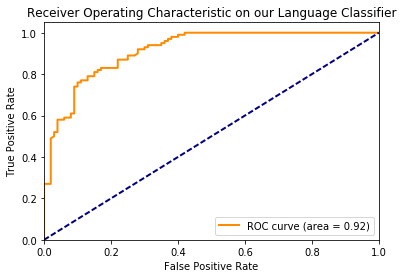

AUC ROC for the plot: 0.92


In [9]:
auc_roc = LanguageDiscriminator(english_lstm, french_lstm).plot_roc_curve()
print("AUC ROC for the plot: {:.2f}".format(auc_roc))

* Is this model good?

<span style="color:darkblue">Yes, this model is really good: it shows an average accuracy of <b>0.82</b> and an AUC-ROC of <b>0.92</b>. There is still room for improvements but it shows that both LSTM models have understood the underlying structure of languages they're working on.</span>

* What are at least three alternatives to language detection that you can think of or find on the internet? What are the pros and cons of each approach?

<div style="color:darkblue">
<ul>
<li>N-grams</li>
<li>Term Frequency</li>
<li>Mutual Information</li>
</ul>
Please read our [blog post](http://timothee.monceaux.me/blog/2017/04/24/lstm-for-language-detection.html) for more explanations about these methods
</div>

* Briefly describe at least 5 ways that you can improve this model, and what you think the value and predicted result of each approach would be? Example: “could use GPUs for training -> faster to get datasets; no change in efficacy”


<div style="color:darkblue">
<ul>
<li>Tune the LSTM -> change hyperparameters to improve the results</li>
<li>Increase the corpus size -> more training, better results</li>
<li>Changing the charset -> get the model more focused on what really matters</li>
<li>Form of bagging where a same language would get multiple LSTM nets -> Increase accuracy</li>
<li>Mix LSTM layers with anything else than a dense layer -> More complete model, better results</li>
</ul>
Please read our [blog post](http://timothee.monceaux.me/blog/2017/04/24/lstm-for-language-detection.html) for more explanations about these methods
</div>

## Part 2 -- Extra Credit [up to 40 points]
For extra credit you should explore improvements to the language detection experiment. You are free to choose, and the amount of extra credit will be subjectively assigned based on how complete, interesting and effective the approach is at improving the experiment. Note that you don’t have to necessarily improve your detector results; some baseline experiments that might be expected to perform poorly may still be valuable for educational purposes.

Some examples:
* Train models for all languages. How do you score, then?
* Explore early stopping by monitoring the validation dataset fit.
* Explore variations in the hyperparameters of the model, including the size and number of LSTM layers.
* Compare to simpler methods like n-grams or hmms or others.

### Training models for all languages

In [223]:
import itertools
# removed czc, grk, jpn, lat, lit, rmn1, rus, ukr for they have characters unrecognized by python
# making an actual classifier would be pretty easy based on this
languages = ['dns', 'dut', 'eng', 'frn', 'ger', 'hng', \
             'itn', 'ltn', 'ltn1', 'lux', 'mls', \
             'por', 'rum', 'spn', 'yps']

res_languages = pandas.DataFrame('-', index=languages, columns=languages)
for lang1, lang2 in itertools.combinations(languages, 2): # for all combinations of languages
    print(lang1, lang2) # we prompt the advancement of the computation
    res_languages.ix[lang1][lang2] = LanguageDiscriminator(LSTM(Dataset("data/"+lang1+".txt")).train(), LSTM(Dataset("data/"+lang2+".txt")).train()).score()
    res_languages.ix[lang2][lang1] = res_languages.ix[lang1][lang2] # the matrix is symetric
    clear_output()

res_languages

,dns,dut,eng,frn,ger,hng,itn,ltn,ltn1,lux,mls,por,rum,spn,yps
dns,-,0.845,0.845,0.865,0.85,0.93,0.92,0.915,0.94,0.885,0.95,0.92,0.93,0.93,0.92
dut,0.845,-,0.89,0.91,0.845,0.875,0.91,0.935,0.92,0.865,0.935,0.94,0.95,0.91,0.94
eng,0.845,0.89,-,0.835,0.855,0.955,0.88,0.86,0.84,0.885,0.96,0.865,0.88,0.83,0.965
frn,0.865,0.91,0.835,-,0.885,0.965,0.81,0.83,0.82,0.895,0.935,0.85,0.85,0.795,0.97
ger,0.85,0.845,0.855,0.885,-,0.93,0.94,0.935,0.92,0.825,0.95,0.94,0.925,0.94,0.945
hng,0.93,0.875,0.955,0.965,0.93,-,0.96,0.935,0.955,0.92,0.94,0.945,0.97,0.95,0.95
itn,0.92,0.91,0.88,0.81,0.94,0.96,-,0.89,0.865,0.925,0.91,0.795,0.875,0.87,0.955
ltn,0.915,0.935,0.86,0.83,0.935,0.935,0.89,-,0.63,0.905,0.945,0.815,0.825,0.88,0.945
ltn1,0.94,0.92,0.84,0.82,0.92,0.955,0.865,0.63,-,0.92,0.94,0.855,0.835,0.875,0.95
lux,0.885,0.865,0.885,0.895,0.825,0.92,0.925,0.905,0.92,-,0.925,0.89,0.905,0.93,0.955


<span style="color:darkblue">As we can tell from these results, our model is pretty consistent with the all tested languages, with the exception or <i>ltn vs. ltn1</i>, for these languages are extremely close together. Our best results are <i>yps vs frn</i> and <i>yps vs por</i> with an accuracy of <b>0.97</b>, which is an excellent score.</span>

### Exploring variations of Hyperparamters
<div style="color:darkblue"><br>
For this part, we studied the influence of the following hyperparameters:
<ul><li><b>Size of the substring (default 5):</b></li></ul>
</div>

In [208]:
to_test = [2, 3, 5, 10, 15, 20, 30, 40, 50]
res_substr_size = pandas.DataFrame(columns=["Accuracy", "Time"], index=to_test)
for size_of_the_substring in to_test:
    t = time()
    print("size_of_the_substring: ",size_of_the_substring)
    res_substr_size.ix[size_of_the_substring]["Accuracy"] = LanguageDiscriminator(LSTM(Dataset(substr_size=size_of_the_substring)).train(), LSTM(Dataset("data/frn.txt", substr_size=size_of_the_substring)).train()).score()
    res_substr_size.ix[size_of_the_substring]["Time"] = time()-t
    clear_output()
res_substr_size

,Accuracy,Time
2,0.66,44.8667
3,0.745,56.6141
5,0.8,89.146
10,0.9,206.376
15,0.985,392.82
20,0.965,599.342
30,1,1284.11
40,1,2022.78
50,0.62,3049.9


<div style="color:darkblue">As we can tell from the output above, the size of the substring has a <b>great influence</b> over the the accuracy and computational time. It grows continuously until 40, and at that point it starts to <b>overfit</b> and decrease rapidly to a point at which it's only slightly better than chance.
<br><br>
<i><u>Note:</u> At substring size of 30 and 40, the computed accuracy is 1. That doesn't mean that the actual accuracy of our model is 100%. Indeed, as we only tested it on 200 samples, and it got every single one of them right, that means that <b>the accuracy of our model is >0.995</b></i><br><br>
<i><u>Note:</u> The size of the substring isn't the only influential parameter in this experience, as it also has a side effect. Indeed, as we are also training on every padded version of each substring, increasing their size will also increase the size of the training set. This partly explains the better results, but also the longer computational time.</i></div>

<div style="color:darkblue"><ul><li><b>Number of training epochs (default 5):</b></li></ul></div>

In [203]:
to_test = [2, 3, 5, 10, 15, 20, 30, 40, 50]
res_n_epochs = pandas.DataFrame(columns=["Accuracy", "Time"], index=to_test)
for n_epochs in to_test:
    t = time()
    print("n_epochs: ",n_epochs)
    res_n_epochs.ix[n_epochs]["Accuracy"] = LanguageDiscriminator(LSTM(Dataset()).train(epochs=n_epochs), LSTM(Dataset("data/frn.txt")).train(epochs=n_epochs)).score()
    res_n_epochs.ix[n_epochs]["Time"] = time()-t
    clear_output()
res_n_epochs

,Accuracy,Time
2,0.8,46.6343
3,0.785,59.4425
5,0.815,85.4587
10,0.8,147.736
15,0.84,210.961
20,0.85,276.881
30,0.795,403.249
40,0.79,524.788
50,0.785,647.926


<span style="color:darkblue">As we can tell from the output above, the number of training epochs doesn't have much influence over the accuracy of our model. The accuracy seems to gradually, slowly increase intil about 20 epochs, where it starts to <b>overfit</b> and fall back. The computational time increases linearly to the number of training epochs, which is kind of intuitive.</span>

<div style="color:darkblue"><ul><li><b>Set of character used (default r'[a-z+\d+ \\.,;"'?!-_:]'):</b></li></ul><br>
For this part, we computed four different versions of both <i>eng.txt</i> and <i>frn.txt</i> to the following different sets of characters:
<ul>
<li><i>everything:</i> default version</li>
<li><i>no_punctuation:</i> keep only letters, numbers and spaces</li>
<li><i>no_punctuation_digits:</i> keep only letters and spaces</li>
<li><i>no_punctuation_digits_spaces:</i> keep only letters</li>
</ul></div>

In [212]:
to_test = ["no_punctuation", "no_punctuation_digits", "no_punctuation_digits_spaces"]
res_charset = pandas.DataFrame(columns=["Accuracy", "Time"], index=["everything"]+to_test)
t = time()
res_charset.ix["everything"]["Accuracy"] = LanguageDiscriminator(LSTM(Dataset()).train(), LSTM(Dataset("data/frn.txt")).train()).score()
res_charset.ix["everything"]["Time"] = time()-t
for charset in to_test:
    t = time()
    print("charset: ", charset)
    res_charset.ix[charset]["Accuracy"] = LanguageDiscriminator(LSTM(Dataset("data/eng_"+charset+".txt")).train(), LSTM(Dataset("data/frn_"+charset+".txt")).train()).score()
    res_charset.ix[charset]["Time"] = time()-t
    clear_output()
res_charset

,Accuracy,Time
everything,0.84,107.585
no_punctuation,0.785,109.083
no_punctuation_digits,0.815,103.357
no_punctuation_digits_spaces,0.815,92.1093


<span style="color:darkblue">As we can tell from the output above, the set of characters used has very little influence over the accuracy of our model. The best score is still when the charset used is the default one, the one with everything. We can guess that punctuation and spaces help captures the internal structure of English and French languages.</span>

### Applying the model to other texts
<div style="color:darkblue">
For this part, we tried training our LSTM models on different datasets and different types of texts to see what quality of content it could generate. We trained our model on the following datasets:<br>
<ul><li><b>Wikipedia Articles (random paragraphs from random wikipedia articles):</b></li></ul></div>

In [225]:
LSTM(Dataset("data/wiki.txt", substr_size=15)).train().generate(size=2500)

Epoch 1/5
95328/95328 [==============================] - 87s - loss: 2.1606    
Epoch 2/5
95328/95328 [==============================] - 53s - loss: 1.3820    
Epoch 3/5
95328/95328 [==============================] - 51s - loss: 1.0714    
Epoch 4/5
95328/95328 [==============================] - 47s - loss: 0.9413    
Epoch 5/5
95328/95328 [==============================] - 48s - loss: 0.8651    

Generated from the seed " by the revenge":
 by the revenge ason was mostook to producers of the brong, knownine nerds aired corralio and he was hor the say affece comby, thetrated held the contucky of the season wassond securly frouge or new york ciedt as ans" he was arred only badully undwa ibborst. tan is sid layonksord it aumod only culs assoce relth so audy to produce only spy: currdard th stealicathedrapic eali is added the trogen, sometor instruments well-squestrume hed with the roon, boham also abson was hosted by actord diocetract to the trace a or bellionsity subwly sul, in prosecute

<span style="color:darkblue">We can see from the output above that the results are note as good as what we could expect. This may be due to the fact that Wikipedia articles tells about a wide variety of subjects with a lot a really specific/technical words and names, thus quickly become over-complicated for our model. We should try on a text with a much smaller vocabulary.</span>

<div style="color:darkblue"><ul><li><b>Novel extracts (random paragraphs from Jack London - Martin Eden):</b></li></ul></div>

In [226]:
LSTM(Dataset("data/novel.txt", substr_size=15)).train().generate(size=2500)

Epoch 1/5
215680/215680 [==============================] - 144s - loss: 1.8368   
Epoch 2/5
215680/215680 [==============================] - 115s - loss: 1.3656   
Epoch 3/5
215680/215680 [==============================] - 115s - loss: 1.1838   
Epoch 4/5
215680/215680 [==============================] - 115s - loss: 1.0895   
Epoch 5/5
215680/215680 [==============================] - 117s - loss: 1.0296   

Generated from the seed "n she had taken":
n she had taken the was no so far nearer, talking nearybeahing come than the world, and to the fast looking of soul out lefior to feie caced ly of eyes ff orld so lave gyinssinuthe mean worked the poare, anot him, like fee scove a scarions and was was a nurry. pointent of anothe so faist oper dient and form him and the two fight-fly he the old of broak, ruth. he so faint o blact morie wee no so fal coass in the time and she would no make sudeasing so making worlh-ly in thand to the fieriepsoon on toly, lone of soul ,umm noworked with his to

<span style="color:darkblue">As we can tell form the output above, the results are already much better than wikipedia articles. It doesn't quite tell a story, nor even always output real words, but the overall structure is respected. In order to improve the results, maybe we can try working on <b>set of words</b> instead of a set of characters.</span>

<div style="color:darkblue"><ul><li><b>Rap lyrics (cult Eminem songs' lyrics)</b></li></ul>

In [228]:
LSTM(Dataset("data/rap.txt", substr_size=15)).train().generate(size=2500)

Epoch 1/5
253280/253280 [==============================] - 169s - loss: 1.7845   
Epoch 2/5
253280/253280 [==============================] - 132s - loss: 1.3066   
Epoch 3/5
253280/253280 [==============================] - 135s - loss: 1.1474   
Epoch 4/5
253280/253280 [==============================] - 132s - loss: 1.0631   
Epoch 5/5
253280/253280 [==============================] - 134s - loss: 1.0045   

Generated from the seed "that is gaping ":
that is gaping too it with your cannin' yo be the be how why wigh like yo, in want to seour just lost it i'm job for with the with my han to examain than to stain to i cannto tan' to start it, i don't warn to be the beside, who lose-mout lick to, shit we acaust so i ain' to kneed to sk it that with the soldiers up in hance to know it the s in it i ain't way to words with my sincle bit by yid i hash't to so empty withougn to be the be h wert enfuct they s bizin' i hond to blow mhine to stop my foriers us an en with my cold orf my who wies i 

<span style="color:darkblue">As we can tell from the output above, the results are quite encouraging, and even really funny as long you've got some imagination: <i>"so i went the shit we acat i were lost it to cross,", "so i ain lour to a start a rhyme i'm back", "try to forge an exatow to forget yo you so i ail jost show in it", "your jawsf never will, fuc wint!"</i>. This model obviously isn't ready to write some real rap lyrics, but it definitely shows that there are a lot of things we can do in this domain.</span>

### Compare with other methods: N-grams
<br>
<div style="color:darkblue">Instead of using a complex method like the LSTMs, we're going to use a very simple statistical method based on n-grams and compare the results.</div>

In [48]:
from nltk import ngrams

# Set some global constants
LANGUAGES = {'eng': 'english', 'frn': 'french'} # Languages to load 
DATA_PATH = os.path.join(os.getcwd(), './data/') # Where to find the Kaggle Dataset

In [49]:
# Loads a text corpus
def load_txt(path):
    with open(path, 'r') as file:
        return file.read()

In [50]:
# Helper to remove chars that will not be correctly encoded
def remove_unknown(text):
    return re.sub(r'[^(a-z)+\d+ \.,;"\'\?!\-_:)]', '', re.sub(r'[\n\t]', ' ', text.lower())).strip()

In [51]:
def load_language_corpuses(languages=LANGUAGES, path=DATA_PATH):
    corpuses = {}
    for langid, lang in languages.items():
        corpuses[lang] = remove_unknown(load_txt(os.path.join(path, langid + '.txt')))
    return corpuses

corpuses = load_language_corpuses()

<div style="color:darkblue">The main part of this is to generate a bunch of bigrams and trigrams from the training data.</div>

In [52]:
def gen_ngrams(text, nrange=[2, 3]):
    ng = []
    for n in nrange:
        ng += ngrams(text, n)
    return ng

def split_text(text, test_split=.2):
    train_len = int(len(text)*(1-test_split))
    return text[:train_len], text[train_len:]

def gen_ngrams_for_corpus(corpuses, nrange=[2, 3], test_split=.2):
    train_grams = {}
    test_grams = {}
    for lang, text in corpuses.items():
        tr, te = split_text(text, test_split)
        train_grams[lang] = gen_ngrams(tr, nrange)
        test_grams[lang] = gen_ngrams(te, nrange)
    return train_grams, test_grams

corpuses_train_grams, corpuses_test_grams = gen_ngrams_for_corpus(corpuses)

<div style="color:darkblue">Then, we just count how many times they actually appear.</div>

In [53]:
def gen_ngram_freqs(ngrams):
    apparitions = {}
    tot_app = len(ngrams)
    for ngram in ngrams:
        if ngram in apparitions:
            apparitions[ngram] += 1
        else:
            apparitions[ngram] = 1
    ng_freq = {}
    for ng, app in apparitions.items():
        ng_freq[ng] = float(app)/float(tot_app)
    return ng_freq

ngram_freq_en = gen_ngram_freqs(corpuses_train_grams['english'])
ngram_freq_fr = gen_ngram_freqs(corpuses_train_grams['french'])

<div style="color:darkblue">Finally, we can score some test bigrams and trigrams by just looking up the frequencies.</div>

In [54]:
def score_ng(ngram_freqs, ngrams_test):
    score = 0
    for gram in ngrams_test:
        if gram in ngram_freqs:
            score += ngram_freqs[gram]
    return score

score_ng(ngram_freq_en, corpuses_test_grams['english'])

12.738775985558583

<div style="color:darkblue">By comparing the score for each model, we can make prediction and therefore get the accuracy.</div>

In [55]:
def ng_accuracy(freq_lang1, freq_lang2, test_lang1, test_lang2, substr=5, nrange=[2,3]):
    correct = 0
    total = 0
    for i in range(len(test_lang1)):
        text = test_lang1[i:i+substr]
        grams = gen_ngrams(text, nrange)
        total += 1
        if score_ng(freq_lang1, grams) > score_ng(freq_lang2, grams):
            correct += 1
    for i in range(len(test_lang2)):
        text = test_lang2[i:i+substr]
        grams = gen_ngrams(text, nrange)
        total += 1
        if score_ng(freq_lang2, grams) > score_ng(freq_lang1, grams):
            correct += 1
    return float(correct)/float(total)

_, en_test_text = split_text(corpuses['english'])
_, fr_test_text = split_text(corpuses['french'])

ng_accuracy(ngram_freq_en, ngram_freq_fr, en_test_text, fr_test_text)

0.7491204925241864

<div style="color:darkblue">Given the simplicity of the model, the results are fairly good. But once tuned, the LSTMs have proven themselves to be capable of much higher scores.</div>